In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import ShuffleSplit
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.base import clone
import requests
from io import StringIO

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
s = requests.get(url).text
df = pd.read_csv(StringIO(s), header=None)
X = df.iloc[:, :-1].astype(float).values
y = df.iloc[:, -1].map({'g':1, 'b':0}).astype(int).values

In [ ]:
class HLTEsk(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=0.3, n_trees=100, max_depth=4, random_state=None,
                 lr_penalty='l2', lr_C=1.0, lr_solver='lbfgs', normalize_residuals=False):
        self.alpha = alpha
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.random_state = random_state
        self.lr_penalty = lr_penalty
        self.lr_C = lr_C
        self.lr_solver = lr_solver
        self.normalize_residuals = normalize_residuals
        self._is_fitted = False

    def fit(self, X, y):
        X, y = check_X_y(X, y, dtype=np.float64)
        self.lr_ = LogisticRegression(
            random_state=self.random_state,
            penalty=self.lr_penalty,
            C=self.lr_C,
            solver=self.lr_solver,
            max_iter=1000
        )
        self.lr_.fit(X, y)
        p_lr = self.lr_.predict_proba(X)[:, 1]
        residuals = y - p_lr
        if self.normalize_residuals:
            residuals = (residuals - residuals.mean()) / (residuals.std() + 1e-9)
        self.trees_ = []
        rng = np.random.RandomState(self.random_state)
        for i in range(int(self.n_trees)):
            idx = rng.choice(len(X), size=len(X), replace=True)
            seed = None if self.random_state is None else int(self.random_state) + i
            tree = DecisionTreeRegressor(max_depth=int(self.max_depth), random_state=seed)
            tree.fit(X[idx], residuals[idx])
            self.trees_.append(tree)
        self._is_fitted = True
        return self

    def predict_proba(self, X):
        check_is_fitted(self, "lr_")
        X = check_array(X, dtype=np.float64)
        p_lr = self.lr_.predict_proba(X)[:, 1]
        tree_preds = np.column_stack([t.predict(X) for t in self.trees_])
        p_tree = np.mean(tree_preds, axis=1)
        p_tree = np.clip(p_tree, -0.9, 0.9)
        final = p_lr + (1.0 - float(self.alpha)) * p_tree
        final = np.clip(final, 1e-6, 1 - 1e-6)
        return np.vstack([1 - final, final]).T

    def predict(self, X):
        probs = self.predict_proba(X)[:, 1]
        return (probs >= 0.5).astype(int)

    def score(self, X, y):
        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_scores = []
acc_scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(X[train_idx])
    Xte = scaler.transform(X[test_idx])

    model = HLTEsk(alpha=0.7, n_trees=20, max_depth=3, random_state=42)
    model.fit(Xtr, y[train_idx])

    probs = model.predict_proba(Xte)[:, 1]
    preds = (probs >= 0.5).astype(int)

    if len(np.unique(y[test_idx])) < 2:
        print(f"Fold {fold} has single-class test set; skipping ROC-AUC")
        continue

    roc = roc_auc_score(y[test_idx], probs)
    acc = accuracy_score(y[test_idx], preds)
    roc_scores.append(roc)
    acc_scores.append(acc)
    print(f"Fold {fold} ROC-AUC: {roc:.4f}, Accuracy: {acc:.4f}")

Fold 0 ROC-AUC: 0.9829, Accuracy: 0.9437
Fold 1 ROC-AUC: 0.8756, Accuracy: 0.8429
Fold 2 ROC-AUC: 0.9298, Accuracy: 0.8857
Fold 3 ROC-AUC: 0.9547, Accuracy: 0.9571
Fold 4 ROC-AUC: 0.8569, Accuracy: 0.8429


In [ ]:
print("\nHLTE per-fold ROC-AUCs:", np.array(roc_scores))
print("HLTE mean ROC-AUC:", np.mean(roc_scores), "std:", np.std(roc_scores))
print("HLTE mean accuracy:", np.mean(acc_scores))


HLTE per-fold ROC-AUCs: [0.98290598 0.87555556 0.92977778 0.95466667 0.85688889]
HLTE mean ROC-AUC: 0.9199589743589744 std: 0.047355797899635094
HLTE mean accuracy: 0.8944466800804829


In [ ]:
pipe_hlte = Pipeline([('scaler', StandardScaler()), ('hlte', HLTEsk(alpha=0.7, n_trees=20, max_depth=3, random_state=42))])
pipe_log = Pipeline([('scaler', StandardScaler()), ('log', LogisticRegression(max_iter=2000, random_state=42))])
pipe_rf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(n_estimators=100, random_state=42))])
pipe_gb = Pipeline([('scaler', StandardScaler()), ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))])

In [ ]:
from sklearn.model_selection import cross_validate

pipe_hlte = Pipeline([('scaler', StandardScaler()), ('hlte', HLTEsk(alpha=0.7, n_trees=20, max_depth=3, random_state=42))])
pipe_log = Pipeline([('scaler', StandardScaler()), ('log', LogisticRegression(max_iter=2000, random_state=42))])
pipe_rf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(n_estimators=100, random_state=42))])
pipe_gb = Pipeline([('scaler', StandardScaler()), ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))])

models_pipes = {
    'HLTE': pipe_hlte,
    'Logistic': pipe_log,
    'RandomForest': pipe_rf,
    'GradientBoosting': pipe_gb
}

scoring = ['roc_auc', 'accuracy']
results = {}

for name, pipe in models_pipes.items():
    try:
        cv_res = cross_validate(pipe, X, y, cv=skf, scoring=scoring, n_jobs=-1, return_train_score=False, error_score=np.nan)
    except Exception as e:
        print(f"{name} cross_validate raised exception: {e}. Retrying with n_jobs=1.")
        cv_res = cross_validate(pipe, X, y, cv=skf, scoring=scoring, n_jobs=1, return_train_score=False, error_score=np.nan)

    roc_scores = cv_res['test_roc_auc']
    acc_scores = cv_res['test_accuracy']

    roc_mean = np.nanmean(roc_scores)
    roc_std = np.nanstd(roc_scores)
    acc_mean = np.nanmean(acc_scores)
    acc_std = np.nanstd(acc_scores)

    results[name] = {'roc': (roc_mean, roc_std), 'acc': (acc_mean, acc_std)}
    print(f"{name}: ROC-AUC = {roc_mean:.4f} ± {roc_std:.4f}, Accuracy = {acc_mean:.4f} ± {acc_std:.4f}")

if np.isnan(results['HLTE']['roc'][0]):
    print("\nHLTE ROC-AUC is NaN in cross_validate. Use manual StratifiedKFold evaluation to diagnose (non-fatal).")

/tmp/ipython-input-987835686.py:28: RuntimeWarning: Mean of empty slice
  roc_mean = np.nanmean(roc_scores)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


HLTE: ROC-AUC = nan ± nan, Accuracy = 0.8944 ± 0.0485
Logistic: ROC-AUC = 0.8963 ± 0.0646, Accuracy = 0.8859 ± 0.0454
RandomForest: ROC-AUC = 0.9785 ± 0.0115, Accuracy = 0.9344 ± 0.0233
GradientBoosting: ROC-AUC = 0.9647 ± 0.0167, Accuracy = 0.9259 ± 0.0399

HLTE ROC-AUC is NaN in cross_validate. Use manual StratifiedKFold evaluation to diagnose (non-fatal).


In [ ]:
def cv_accuracy(pipe, X, y, cv):
    accs = []
    for train_idx, test_idx in cv.split(X, y):
        if 'scaler' in pipe.named_steps:
            scaler = pipe.named_steps['scaler']
            Xtr = scaler.fit_transform(X[train_idx])
            Xte = scaler.transform(X[test_idx])
        else:
            Xtr = X[train_idx].astype(float)
            Xte = X[test_idx].astype(float)

        clf_name = list(pipe.named_steps.keys())[-1]
        clf = clone(pipe.named_steps[clf_name])
        try:
            clf.fit(Xtr, y[train_idx])
            preds = clf.predict(Xte)
            accs.append(accuracy_score(y[test_idx], preds))
        except Exception:
            accs.append(np.nan)
    return np.array(accs)

acc_hlte = cv_accuracy(pipe_hlte, X, y, skf)
acc_log = cv_accuracy(pipe_log, X, y, skf)
acc_rf = cv_accuracy(pipe_rf, X, y, skf)
acc_gb = cv_accuracy(pipe_gb, X, y, skf)

print("\nCross-val accuracy (HLTE):", np.nanmean(acc_hlte), "+-", np.nanstd(acc_hlte))
print("Cross-val accuracy (Logistic):", np.nanmean(acc_log), "+-", np.nanstd(acc_log))
print("Cross-val accuracy (RF):", np.nanmean(acc_rf), "+-", np.nanstd(acc_rf))
print("Cross-val accuracy (GB):", np.nanmean(acc_gb), "+-", np.nanstd(acc_gb))


Cross-val accuracy (HLTE): 0.8944466800804829 +- 0.04848127674376425
Cross-val accuracy (Logistic): 0.8859154929577464 +- 0.04536766027804028
Cross-val accuracy (RF): 0.9344466800804829 +- 0.023273129651532207
Cross-val accuracy (GB): 0.9258752515090543 +- 0.039865974672461064


In [ ]:
models = {
    "HLTE": HLTEsk(alpha=0.7, n_trees=20, max_depth=3, random_state=42),
    "Logistic": LogisticRegression(max_iter=2000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

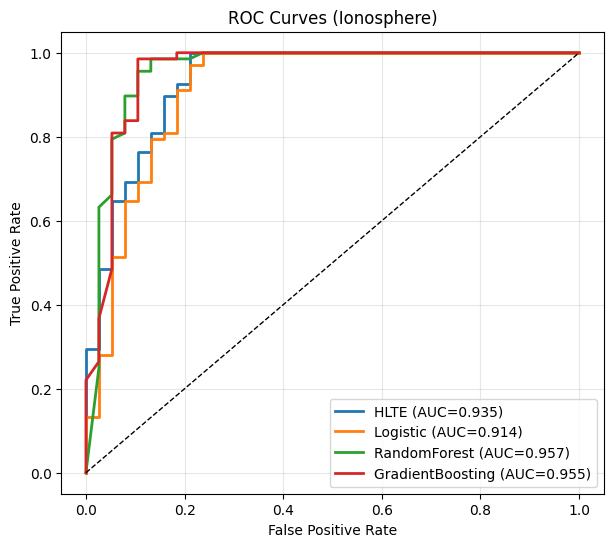

In [ ]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr); Xte_s = scaler.transform(Xte)

plt.figure(figsize=(7,6))
for name, clf in models.items():
    mdl = clf
    mdl.fit(Xtr_s, ytr)
    probs = mdl.predict_proba(Xte_s)[:,1]
    fpr, tpr, _ = roc_curve(yte, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Ionosphere)"); plt.legend(loc="lower right"); plt.grid(alpha=0.3)
plt.show()

/tmp/ipython-input-2629727634.py:6: RuntimeWarning: Mean of empty slice
  acc_mean = np.nanmean(res['test_accuracy']); auc_mean = np.nanmean(res['test_roc_auc'])


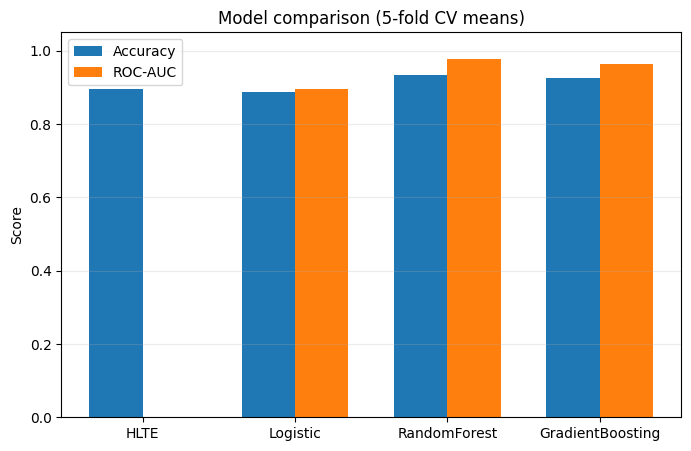

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
names, acc_means, auc_means = [], [], []
for name, clf in models.items():
    pipe = Pipeline([('scaler', StandardScaler()), (name.lower(), clf)])
    res = cross_validate(pipe, X, y, cv=skf, scoring=['accuracy','roc_auc'], n_jobs=-1, error_score=np.nan)
    acc_mean = np.nanmean(res['test_accuracy']); auc_mean = np.nanmean(res['test_roc_auc'])
    names.append(name); acc_means.append(acc_mean); auc_means.append(auc_mean)

x = np.arange(len(names)); w = 0.35
plt.figure(figsize=(8,5))
plt.bar(x - w/2, acc_means, w, label='Accuracy')
plt.bar(x + w/2, auc_means, w, label='ROC-AUC')
plt.xticks(x, names); plt.ylabel("Score"); plt.title("Model comparison (5-fold CV means)")
plt.ylim(0.0,1.05); plt.legend(); plt.grid(axis='y', alpha=0.25)
plt.show()

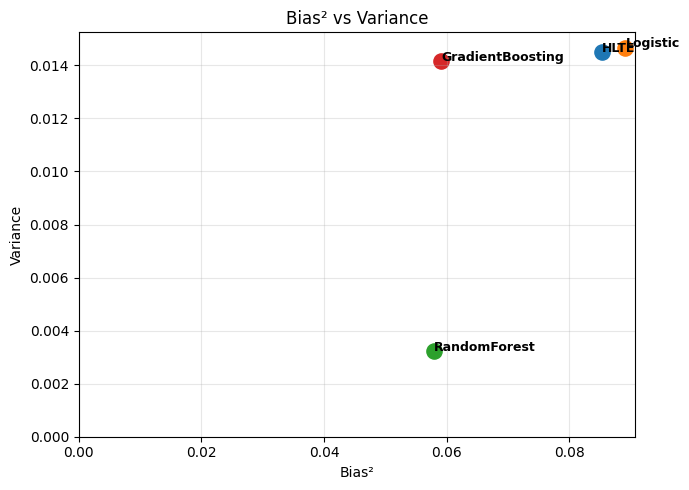

Model	ROC-AUC	Accuracy	Bias^2	Variance
HLTE	nan	0.8944	0.085272	0.014488
Logistic	0.8963	0.8859	0.089140	0.014674
RandomForest	0.9785	0.9344	0.057844	0.003237
GradientBoosting	0.9647	0.9259	0.059104	0.014168


In [ ]:
def bias_variance_probs(model, X, y, n_splits=30, test_size=0.3, reps=12, random_state=42):
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    bias_list, var_list = [], []
    for train_idx, test_idx in ss.split(X, y):
        Xtr, Xte = X[train_idx], X[test_idx]
        ytr, yte = y[train_idx], y[test_idx]
        scaler = StandardScaler().fit(Xtr)
        Xtr_s = scaler.transform(Xtr); Xte_s = scaler.transform(Xte)
        probs_rep = []
        rng = np.random.RandomState(1000)
        for r in range(reps):
            idx_boot = rng.choice(len(Xtr_s), size=len(Xtr_s), replace=True)
            clf = model
            clf.fit(Xtr_s[idx_boot], ytr[idx_boot])
            probs_rep.append(clf.predict_proba(Xte_s)[:,1])
        probs_rep = np.vstack(probs_rep)
        p_mean = probs_rep.mean(axis=0)
        bias_sq = np.mean((yte - p_mean)**2)
        var = np.mean(probs_rep.var(axis=0))
        bias_list.append(bias_sq); var_list.append(var)
    return np.mean(bias_list), np.mean(var_list)

results = {}
for name, clf in models.items():
    b2, v = bias_variance_probs(clf, X, y, n_splits=30, test_size=0.3, reps=12, random_state=42)
    results[name] = (b2, v)

plt.figure(figsize=(7,5))
for name, (b2, v) in results.items():
    plt.scatter(b2, v, s=120)
    plt.text(b2 + 1e-5, v + 1e-6, name, fontsize=9, weight='bold')
plt.xlabel("Bias²"); plt.ylabel("Variance"); plt.title("Bias² vs Variance"); plt.grid(alpha=0.3)
plt.xlim(left=0); plt.ylim(bottom=0); plt.tight_layout(); plt.show()

print("Model\tROC-AUC\tAccuracy\tBias^2\tVariance")
for i, name in enumerate(names):
    print(f"{name}\t{auc_means[i]:.4f}\t{acc_means[i]:.4f}\t{results[name][0]:.6f}\t{results[name][1]:.6f}")